In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
plt.style.use('classic')
from numpy_ext import rolling_apply
from arch.univariate import EWMAVariance
from arch import arch_model

In [48]:
def get_q2_data():
    df =pd.read_csv('./data/QRM-2022-cw1-data-b.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by='Date', ascending=True)
    df.set_index('Date')
    df['logreturn'] = np.log(1 + df['DOG'].pct_change())
    df['loss'] = -1*df['logreturn']
    df['max_loss'] = df['loss'].apply(lambda x: np.max([x,0]))
    return df.set_index('Date')


In [49]:
def es(loss: np.ndarray, var: np.ndarray):
    # check if loss[0 to n inclusive] > var[n+1]
    loss = loss[:-1]
    breach_mask = loss>var[-1]
    if not breach_mask.sum():
        return None
    return loss[breach_mask].sum() / breach_mask.sum()

def es_n(loss: np.ndarray, var: float):
    # check if loss[0 to n inclusive] > var
    breach_mask = loss>var
    if not breach_mask.sum():
        return None
    return loss[breach_mask].sum() / breach_mask.sum()

# Q2 a)

violations 95%: 119, 5.90%
violations 99%: 37, 1.83%


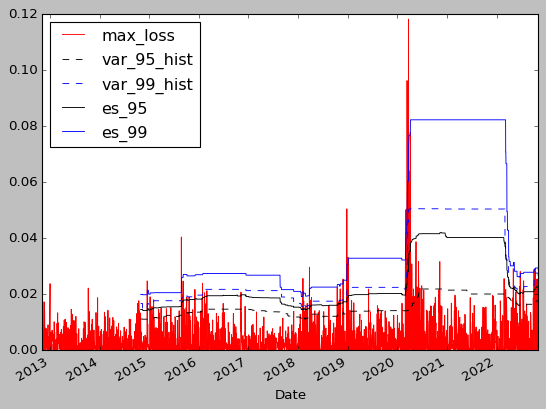

In [50]:
df = get_q2_data()

df['var_95_hist'] = df['loss'].rolling(500).apply(lambda x: np.quantile(x, 0.95)).shift(1)
df['var_99_hist'] = df['loss'].rolling(500).apply(lambda x: np.quantile(x, 0.99)).shift(1)

df['es_95'] = rolling_apply(es, 501, df['loss'].values, df['var_95_hist'].values)
df['es_99'] = rolling_apply(es, 501, df['loss'].values, df['var_99_hist'].values)

df[['max_loss','var_95_hist','var_99_hist','es_95','es_99']].plot(style=['r','k--','b--','k-','b-'], lw=0.8)

num_days = (~df['var_95_hist'].isna()).sum()
viols_95 = (df['loss']>df['var_95_hist']).sum()
viols_99 = (df['loss']>df['var_99_hist']).sum()

print(f"violations 95%: {viols_95}, {100*viols_95/num_days:.2f}%")
print(f"violations 99%: {viols_99}, {100*viols_99/num_days:.2f}%")

# Q2 b)

violations 95%: 102, 5.05%
violations 99%: 24, 1.19%


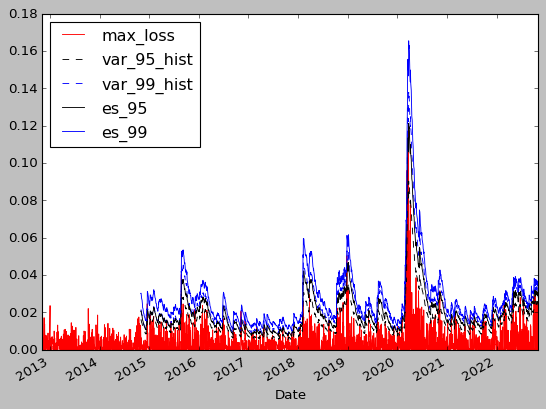

In [51]:
df = get_q2_data()

df['std_forc'] = 0

alpha = 0.06
for i in range(2, len(df)):
    df.iloc[i, 4] = np.sqrt(alpha*(df.iloc[i-1,2]**2) + (1-alpha)*(df.iloc[i-1,4]**2))


df['z_t'] = df['loss']/df['std_forc']
df.replace([np.inf, -np.inf], 0, inplace=True)

# shift 1 as quartile needs the n previous
df['q_95'] = df['z_t'].rolling(500).apply(lambda x: np.quantile(x,0.95)).shift(1)
df['q_99'] = df['z_t'].rolling(500).apply(lambda x: np.quantile(x,0.99)).shift(1)

df['es_95_z_t'] = rolling_apply(es, 501, df['z_t'].values, df['q_95'].values)
df['es_99_z_t'] = rolling_apply(es, 501, df['z_t'].values, df['q_99'].values)



df['var_95_hist'] = df['q_95']*df['std_forc']
df['var_99_hist'] = df['q_99']*df['std_forc']
df['es_95'] = df['std_forc']*df['es_95_z_t']
df['es_99'] = df['std_forc']*df['es_99_z_t']


df[['max_loss','var_95_hist','var_99_hist','es_95','es_99']].plot(style=['r','k--','b--','k-','b-'], lw=0.8)

num_days = (~df['var_95_hist'].isna()).sum()
viols_95 = (df['loss']>df['var_95_hist']).sum()
viols_99 = (df['loss']>df['var_99_hist']).sum()

print(f"violations 95%: {viols_95}, {100*viols_95/num_days:.2f}%")
print(f"violations 99%: {viols_99}, {100*viols_99/num_days:.2f}%")

## Q2 c)

In [62]:
def garch_var(x, alpha):
        
    model = arch_model(x.dropna(),
                    mean='Constant', 
                    vol='GARCH', 
                    p=1, q=1, rescale=False, dist='normal')

    model_fit = model.fit(update_freq=-1, disp=0)
    forecasts = model_fit.forecast(reindex=False)
    var = forecasts.variance.iloc[0,0]
    q = np.quantile(model_fit.std_resid, alpha)
    return q*(var**0.5)

def garch_es(x, alpha):
        
    model = arch_model(x.dropna(),
                    mean='Constant', 
                    vol='GARCH', 
                    p=1, q=1, rescale=False, dist='normal')

    model_fit = model.fit(update_freq=-1, disp=0)
    forecasts = model_fit.forecast(reindex=False)
    var = forecasts.variance.iloc[0,0]
    q = np.quantile(model_fit.std_resid, alpha)
    exp_sh = es_n(model_fit.std_resid, q)
    return q*(var**0.5)*exp_sh

In [63]:
df = get_q2_data()

df['var_95']= df['logreturn'].rolling(500).apply(garch_var, kwargs=dict(alpha=0.95)).shift(1)
df['es_95']= df['logreturn'].rolling(500).apply(garch_es, kwargs=dict(alpha=0.95)).shift(1)

df['var_99']= df['logreturn'].rolling(500).apply(garch_var, kwargs=dict(alpha=0.99)).shift(1)
df['es_99']= df['logreturn'].rolling(500).apply(garch_es, kwargs=dict(alpha=0.99)).shift(1)


# takes ~3m

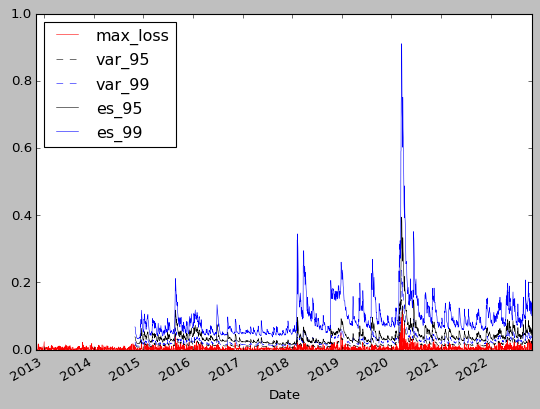

violations 95%: 81, 4.01%
violations 99%: 5, 0.25%


In [65]:

df['max_loss'] = df['loss'].apply(lambda x: np.max([x,0]))
df[['max_loss','var_95','var_99','es_95','es_99']].plot(style=['r','k--','b--','k-','b-'], lw=0.5)
plt.show()

num_days = (~df['var_95'].isna()).sum()
viols_95 = (df['loss']>df['var_95']).sum()
viols_99 = (df['loss']>df['var_99']).sum()

print(f"violations 95%: {viols_95}, {100*viols_95/num_days:.2f}%")
print(f"violations 99%: {viols_99}, {100*viols_99/num_days:.2f}%")
